# **2. MODELOS**

Librerías necesarias

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

Carga de los datos preprocesados

In [2]:
df_propio = pd.read_csv('/content/DiabetesPropio.csv')

Comprobación de que la carga se ha realizado correctamente

In [3]:
df_propio.head()

,ID,Chol,HDL,HbA1c,Age,Gender,BMI,Class,TG,LDL
0,1,5.24958,1.44816,4.31,46,0,22.127086,0,2.274687,2.502406
1,2,4.26690,0.62064,4.44,29,0,37.412677,0,1.954545,2.918182
2,3,5.89608,0.95682,4.64,58,0,48.361808,0,2.274687,2.502406
3,4,2.01708,0.31032,4.63,67,1,18.634579,0,2.662069,3.027586
4,5,6.43914,0.72408,7.72,64,1,27.819896,2,2.419865,2.639075


## Modelos supervisados

Carga de la función de especificidad, necesaria para evaluar los modelos

In [4]:
# Calculo de la especificidad para cada clase
# Parametros: confusion_matrix (matriz de confusion) y class_index (indice de cada clase)
def calc_specificity(confusion_matrix, class_index):
  # Para los verdaderos negativos: selecciona el indice correspondiente a la clase
  # para fila y columna
  tn = confusion_matrix[class_index, class_index]
  # Para los falsos negativos: suma toda la fila de la clase y resta los verdaderos
  # negativos
  fp = np.sum(confusion_matrix[class_index, :]) - tn
  # Se aplica la formula de la especififcidad y se devuelve como valor de la funcion
  specificity = tn / (tn + fp)
  return specificity

### **2.1. Regresion logistica**

Aumentar la muestra con SMOTE para conseguir mejor rendimiento de la clase 2.

In [5]:
# Variables independientes
X = df_propio.drop(columns=['Class', 'ID'])

# Variable objetivo
y = df_propio['Class']

# Division train 80% y test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=60)

# Aplica SMOTE al conjunto de train
# con el objetivo de aumentar las observaciones de la clase minoritaria
oversampler = SMOTE(random_state=60)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

# Estandarizar las variables usando una instnacia de StandardScaler
# con el objetivo de que no predomine una caracteristica por encima de otra
scaler = StandardScaler()
X_train_oversampled = scaler.fit_transform(X_train_oversampled)
X_test = scaler.transform(X_test)

# Creacion del modelo de regresion logistica
# Parametros utilizados para crear la regresion logistica:
# metodo: ovr (one-vs-rest) que entrena m modelos binarios para cada una
# de las clases y obtener un mejor entrenamiento
# maximo de iteraciones: 50, para evitar overfitting
# algoritmo de optimizacion: liblinear
# control del equilibrio entre el ajuste y la regularizacion: 100
modelo_lg = LogisticRegression(multi_class='ovr', solver='liblinear', C=100, max_iter=50)

# Entrenamiento del modelo
modelo_lg.fit(X_train_oversampled, y_train_oversampled)

# Prediccion de las etiquetas en el conjunto de test
y_pred = modelo_lg.predict(X_test)

Representacion grafica de la clasificación realizada por el modelo con el conjunto de datos en test

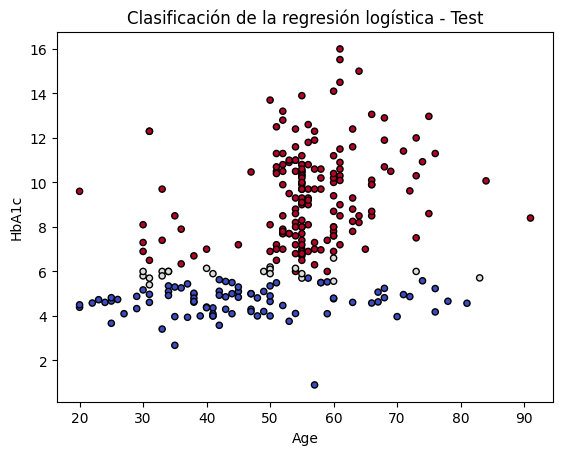

In [6]:
# Invierte la transformación de scaler para la representacion
X_test_original = X_test * scaler.scale_ + scaler.mean_
# Creacion del grafico
plt.scatter(X_test_original [:, 3], X_test_original [:, 2], c=y_pred, cmap=plt.cm.coolwarm, edgecolors='black', s=20)
plt.title("Clasificación de la regresión logística - Test")
plt.xlabel("Age")
plt.ylabel("HbA1c")
plt.show()

Visualización de la clasificación realizada por el modelo en test según bien/mal clasificado el punto de datos

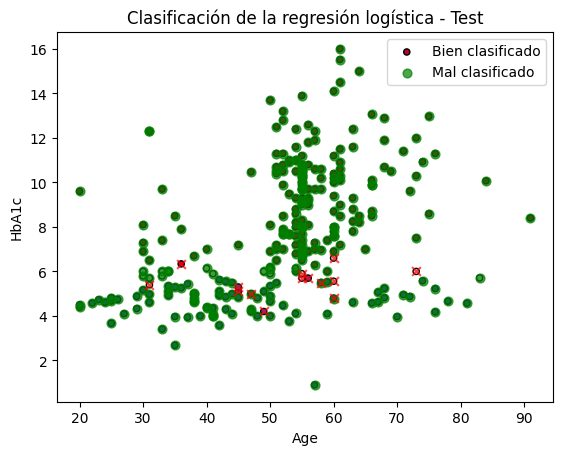

In [7]:
# Observaciones correctamente clasificadas
correct_classif = y_pred == y_test

# Observaciones mal clasificadas
incorrect_classif = ~correct_classif

# Graficar las observaciones
plt.scatter(X_test_original[:, 3], X_test_original[:, 2], c=y_pred, cmap=plt.cm.coolwarm, edgecolors='black', s=20)
plt.title("Clasificación de la regresión logística - Test")
plt.xlabel("Age")
plt.ylabel("HbA1c")

# Visualizacion de las observaciones bien clasificadas en verde
plt.scatter(X_test_original[correct_classif, 3], X_test_original[correct_classif, 2], c='green', marker='o', s=40, alpha=0.7)

# Visualizacion de las observaciones mal clasificadas en rojo
plt.scatter(X_test_original[incorrect_classif, 3], X_test_original[incorrect_classif, 2], c='red', marker='x', s=40, alpha=0.7)

# Leyenda
plt.legend(['Bien clasificado', 'Mal clasificado'], loc='best')
plt.show()

**Resultados en test**

Matriz de confusion

Matriz de confusión para test:
[[ 81   2   0]
 [  0  15   1]
 [  7   4 170]]


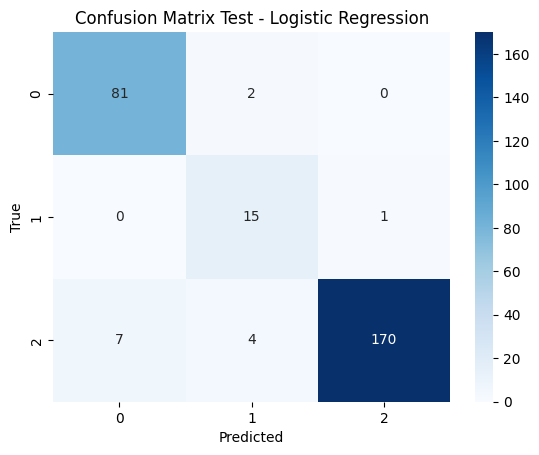

In [8]:
# Matriz de confusión para train
cm_train = confusion_matrix(y_train_oversampled, modelo_lg.predict(X_train_oversampled))

# Matriz de confusión para test
cm_test = confusion_matrix(y_test, y_pred)

# Imprime la matriz de confusion en test
print("Matriz de confusión para test:")
print(cm_test)

# Visualizacion de la matriz de confusion en test
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Test - Logistic Regression')
plt.show()

Metricas en test

In [9]:
# Calculo de las métricas para test
# Se calculan precision, recall, f1-score y especificidad
report_lg_test = classification_report(y_true=y_test, y_pred=y_pred)
print('Métricas para test:')
print(report_lg_test)

Métricas para test:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        83
           1       0.71      0.94      0.81        16
           2       0.99      0.94      0.97       181

    accuracy                           0.95       280
   macro avg       0.88      0.95      0.91       280
weighted avg       0.96      0.95      0.95       280



Calculo de la especificidad que no viene en el report

In [10]:
# Calculo de la especificidad para las clases en la regresion logistica
specificity_class0_lg = calc_specificity(cm_test, 0)
specificity_class1_lg = calc_specificity(cm_test, 1)
specificity_class2_lg = calc_specificity(cm_test, 2)

# Impresion por pantalla
print('Especificidad por clase en test:')
print("Especificidad clase 0:", specificity_class0_lg)
print("Especificidad clase 1:", specificity_class1_lg)
print("Especificidad clase 2:", specificity_class2_lg)

Especificidad por clase en test:
Especificidad clase 0: 0.9759036144578314
Especificidad clase 1: 0.9375
Especificidad clase 2: 0.9392265193370166


Curvas ROC para cada clase

AUC por clase:
Sin diabetes: 0.989
Prediabetes: 0.935
Diabetes: 0.974


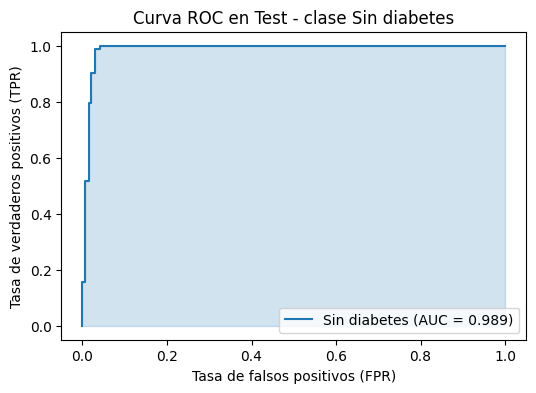

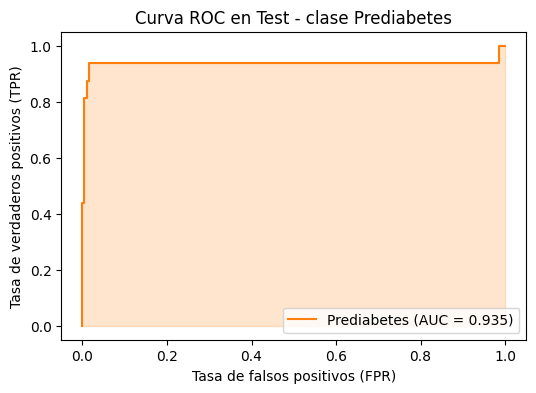

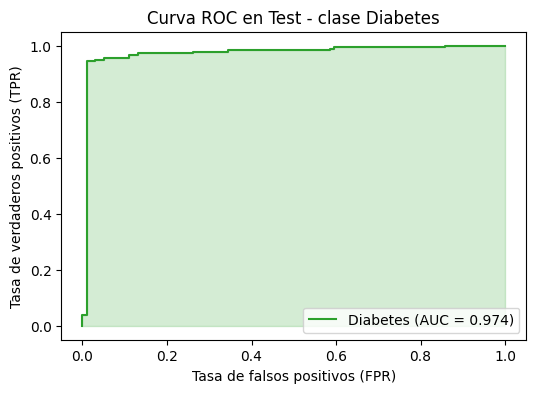

In [11]:
# Cargar las etiquetas reales y las predicciones de probabilidad en test
y_true = y_test
y_pred_proba = modelo_lg.predict_proba(X_test)

# Colores para las curvas, un color por cada clase
colores = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Nombre de las clases
class_names = ['Sin diabetes', 'Prediabetes', 'Diabetes']

# Curva ROC para cada una de las 3 clases
for i in range(3):
    # Binarizar las etiquetas y las predicciones para la clase i
    y_true_bin = (y_true == i).astype(int)
    # Extraer las probabilidades para una clase determinada
    y_pred_proba_bin = y_pred_proba[:, i]

    # Calcular FPR, TPR y AUC para poder graficar la curva
    fpr, tpr, thresholds = roc_curve(y_true_bin, y_pred_proba_bin)
    auc_score = auc(fpr, tpr)

    # Graficar la curva ROC individual para cada clase
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color=colores[i], label='{} (AUC = {:.3f})'.format(class_names[i], auc_score))
    plt.fill_between(fpr, tpr, alpha=0.2, color=colores[i])
    plt.xlabel('Tasa de falsos positivos (FPR)')
    plt.ylabel('Tasa de verdaderos positivos (TPR)')
    plt.legend()
    plt.title('Curva ROC en Test - clase ' + class_names[i])


# Mostrar resumen de AUC
print("AUC por clase:")
for i in range(3):
    y_true_bin = (y_true == i).astype(int)
    y_pred_proba_bin = y_pred_proba[:, i]
    # Calculo del auc para cada clase con sus probabilidades
    auc_score = auc(roc_curve(y_true_bin, y_pred_proba_bin)[0],
                    roc_curve(y_true_bin, y_pred_proba_bin)[1])
    print(f"{class_names[i]}: {auc_score:.3f}")

plt.show()

**Resultados en train**

Matriz de confusión

Matriz de confusión para train:
[[680  38   9]
 [ 12 644  71]
 [ 42  32 653]]


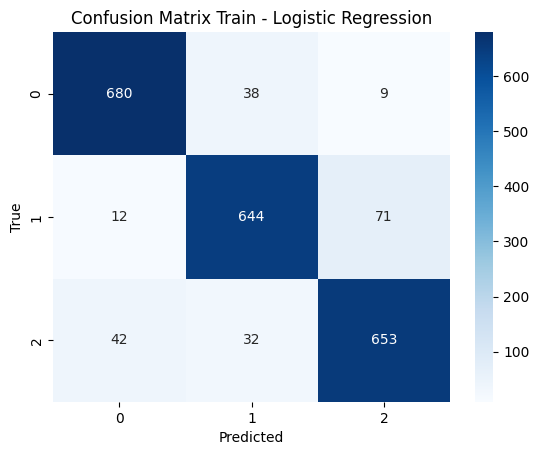

In [12]:
# Visualizar la matriz de confusion en train
print("Matriz de confusión para train:")
print(cm_train)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Train - Logistic Regression')
plt.show()

Métricas

In [13]:
# Calculo de las métricas para train
# Metricas empleadas: precision, recall, f1-score y especificidad
report_lg_train = classification_report(y_true=y_train_oversampled, y_pred=modelo_lg.predict(X_train_oversampled))
print('Métricas para train:')
print(report_lg_train)

Métricas para train:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       727
           1       0.90      0.89      0.89       727
           2       0.89      0.90      0.89       727

    accuracy                           0.91      2181
   macro avg       0.91      0.91      0.91      2181
weighted avg       0.91      0.91      0.91      2181



In [14]:
# Calculo de la especificidad en train
specificity_class0_lg_train = calc_specificity(cm_train, 0)
specificity_class1_lg_train = calc_specificity(cm_train, 1)
specificity_class2_lg_train = calc_specificity(cm_train, 2)

# Imprimir por pantalla
print('Especificidad por clase en train:')
print("Clase 0:", specificity_class0_lg_train)
print("Clase 1:", specificity_class1_lg_train)
print("Clase 2:", specificity_class2_lg_train)

Especificidad por clase en train:
Clase 0: 0.9353507565337001
Clase 1: 0.8858321870701513
Clase 2: 0.8982118294360385


Curva ROC

AUC por clase:
Sin diabetes: 0.976
Prediabetes: 0.941
Diabetes: 0.951


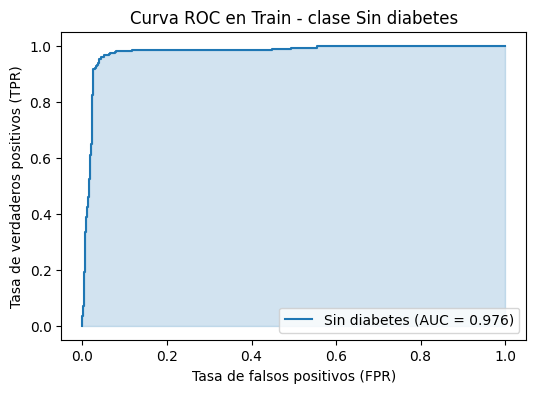

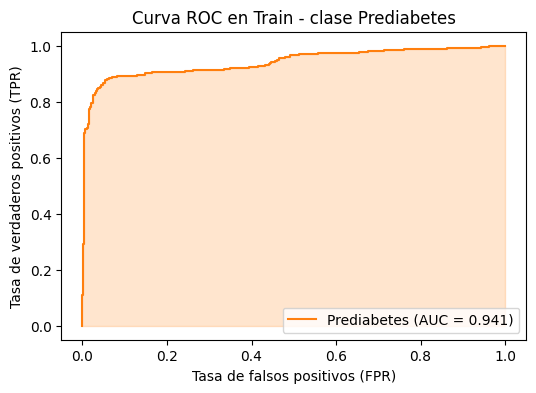

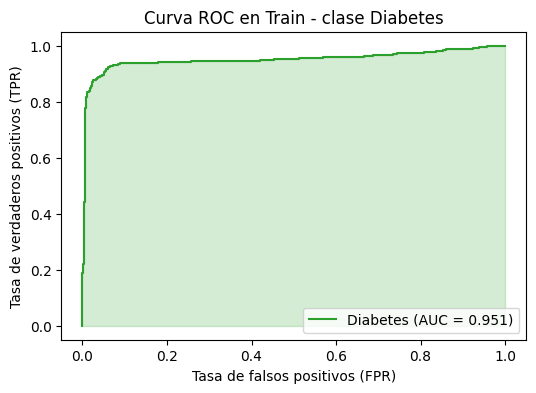

In [15]:
# Cargar las etiquetas reales y las predicciones de probabilidad
y_true = y_train_oversampled
y_pred_proba = modelo_lg.predict_proba(X_train_oversampled)

# Colores para las curvas, un color por clase
colores = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Nombre de las clases
class_names = ['Sin diabetes', 'Prediabetes', 'Diabetes']

# Curva ROC para cada una de las 3 clases
for i in range(3):
    # Binarizar las etiquetas y las predicciones para la clase i
    y_true_bin = (y_true == i).astype(int)
    # Extraer las probabilidades para una clase determinada
    y_pred_proba_bin = y_pred_proba[:, i]

    # Calcular FPR, TPR y AUC para poder graficar la curva
    fpr, tpr, thresholds = roc_curve(y_true_bin, y_pred_proba_bin)
    auc_score = auc(fpr, tpr)

    # Graficar la curva ROC individual
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color=colores[i], label='{} (AUC = {:.3f})'.format(class_names[i], auc_score))
    plt.fill_between(fpr, tpr, alpha=0.2, color=colores[i])
    plt.xlabel('Tasa de falsos positivos (FPR)')
    plt.ylabel('Tasa de verdaderos positivos (TPR)')
    plt.legend()
    plt.title('Curva ROC en Train - clase ' + class_names[i])


# Mostrar resumen de AUC
print("AUC por clase:")
for i in range(3):
    y_true_bin = (y_true == i).astype(int)
    y_pred_proba_bin = y_pred_proba[:, i]
    # Calculo del auc para cada clase con sus probabilidades
    auc_score = auc(roc_curve(y_true_bin, y_pred_proba_bin)[0],
                    roc_curve(y_true_bin, y_pred_proba_bin)[1])
    print(f"{class_names[i]}: {auc_score:.3f}")

plt.show()

### **2.2. Support Vector Machine Radial**

Realización del modelo

In [16]:
# Variables independientes
X = df_propio.drop(columns=['Class', 'ID'])

# Variable objetivo
y = df_propio['Class']

# Division 20% test y 80% train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Establecer la tasa de SMOTE personalizada para evitar overfitting
# clase sin diabetes - 0 : 500 observaciones
# clase prediaabetes - 1 : 100 observaciones
# clase diabetes - 2 : 734 observaciones
sampl_str = {0: 500, 1: 100,  2: 734}

# Aplica SMOTE al conjunto de train
# estableciendo el numero de observaciones por clase segun previamente
# se ha comentado
oversampler = SMOTE(random_state=60, sampling_strategy=sampl_str)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

# Estandariza las variables
# con el objetivo de que no predomine ninguna clase por encima de las demas
# consiguiendo resultados mas precisos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_oversampled)
X_test_scaled = scaler.transform(X_test)

# Creacion del modelo de MSV
# Estableciendo los siguientes parametros:
# kernel: rbf, radial, para mapear los datos a mayor dimension
# equilibrio del modelo: 1, evitando overfitting
# gamma: 0.1, para reeducir el impacto de valores atipicos
modelo_SVC = SVC(kernel='rbf', C=1, gamma=0.1)
modelo_SVC.fit(X_train_scaled, y_train_oversampled)
y_pred_SVC = modelo_SVC.predict(X_test_scaled)

**Resultados obtenidos en train**

Matriz de confusion

[[494   2   4]
 [ 37  45  18]
 [ 20   3 711]]


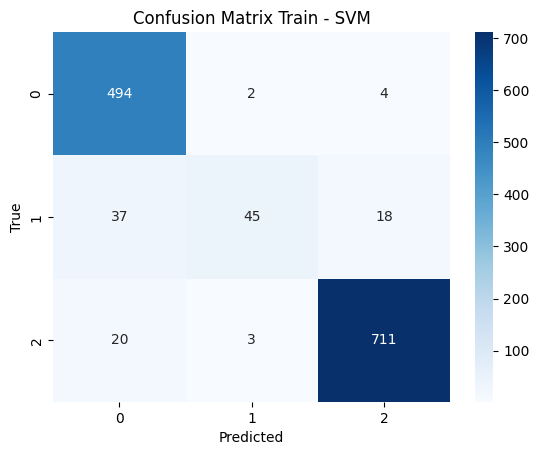

In [17]:
# Calculo de la matriz de confusion para train
train_cm_SVC = confusion_matrix(y_train_oversampled, modelo_SVC.predict(X_train_scaled))
print(train_cm_SVC)

# Visualizacion de la matriz para train
sns.heatmap(train_cm_SVC, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Train - SVM')
plt.show()

Métricas

In [18]:
# Calculo de las métricas para train
# Metricas empleadas: precision, recall, f1-score y especificidad
report_SVM_train = classification_report(y_true=y_train_oversampled, y_pred=modelo_SVC.predict(X_train_scaled))
print('Métricas para train:')
print(report_SVM_train)

Métricas para train:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       500
           1       0.90      0.45      0.60       100
           2       0.97      0.97      0.97       734

    accuracy                           0.94      1334
   macro avg       0.92      0.80      0.84      1334
weighted avg       0.94      0.94      0.93      1334



In [19]:
# Caluclo de la especificidad
specificity_class_SVM_train_0 = calc_specificity(train_cm_SVC, 0)
specificity_class_SVM_train_1 = calc_specificity(train_cm_SVC, 1)
specificity_class_SVM_train_2 = calc_specificity(train_cm_SVC, 2)

# Impresion por pantalla
print('Especificidad por clase en train:')
print("Especificidad clase 0:", specificity_class_SVM_train_0)
print("Especificidad clase 1:", specificity_class_SVM_train_1)
print("Especificidad clase 2:", specificity_class_SVM_train_2)

Especificidad por clase en train:
Especificidad clase 0: 0.988
Especificidad clase 1: 0.45
Especificidad clase 2: 0.9686648501362398


curva ROC

AUC por clase:
Sin diabetes: 0.991
Prediabetes: 0.791
Diabetes: 0.990


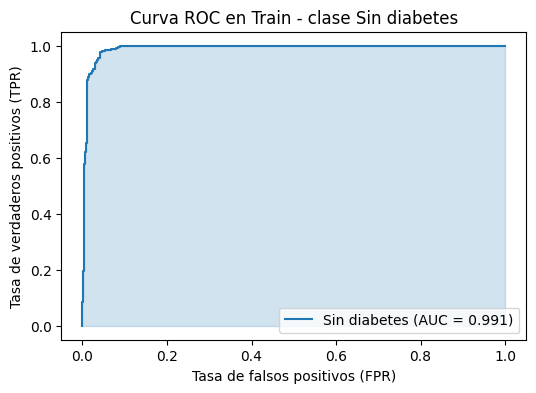

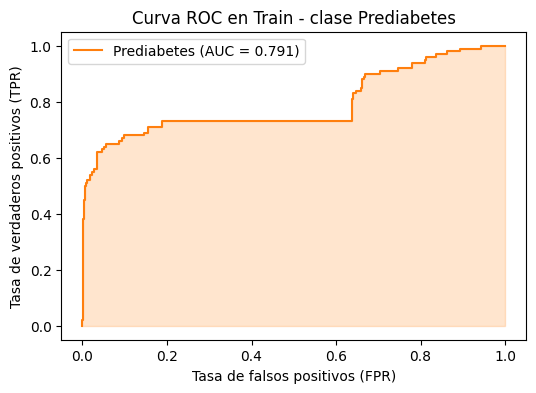

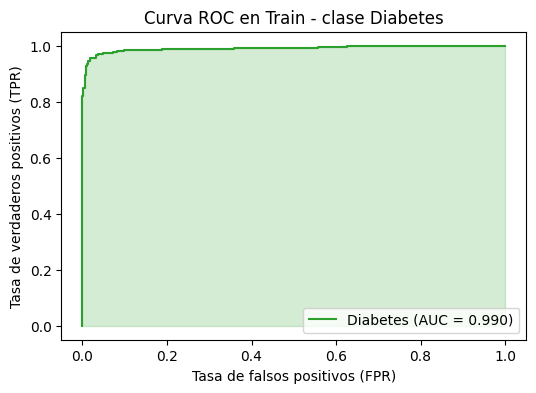

In [20]:
# Cargar las etiquetas reales y las predicciones de probabilidad
y_true = y_train_oversampled
y_pred_proba = modelo_SVC.decision_function(X_train_scaled)

# Colores para las curvas, un color por cada curva
colores = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Nombre de las clases
class_names = ['Sin diabetes', 'Prediabetes', 'Diabetes']

# Curva ROC para cada una de las 3 clases
for i in range(3):
    # Binarizar las etiquetas y las predicciones para la clase i
    y_true_bin = (y_true == i).astype(int)
    # Extraer las probabilidades para una clase determinada
    y_pred_proba_bin = y_pred_proba[:, i]

    # Calcular FPR, TPR y AUC para poder graficar la curva
    fpr, tpr, thresholds = roc_curve(y_true_bin, y_pred_proba_bin)
    auc_score = auc(fpr, tpr)

    # Graficar la curva ROC individual
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color=colores[i], label='{} (AUC = {:.3f})'.format(class_names[i], auc_score))
    plt.fill_between(fpr, tpr, alpha=0.2, color=colores[i])
    plt.xlabel('Tasa de falsos positivos (FPR)')
    plt.ylabel('Tasa de verdaderos positivos (TPR)')
    plt.legend()
    plt.title('Curva ROC en Train - clase ' + class_names[i])

# Mostrar resumen de AUC
print("AUC por clase:")
for i in range(3):
    y_true_bin = (y_true == i).astype(int)
    y_pred_proba_bin = y_pred_proba[:, i]
    # Calculo del auc para cada clase con sus probabilidades
    auc_score = auc(roc_curve(y_true_bin, y_pred_proba_bin)[0],
                    roc_curve(y_true_bin, y_pred_proba_bin)[1])
    print(f"{class_names[i]}: {auc_score:.3f}")

plt.show()

**Resultados en test**

Matriz de confusión

[[ 88   0   3]
 [  7   7   1]
 [  6   2 166]]


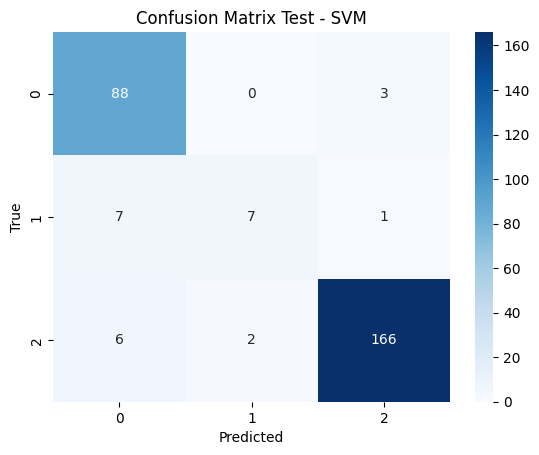

In [21]:
# Calculo de la matriz de confusion para test
test_cm_SVC = confusion_matrix(y_test, y_pred_SVC)
print(test_cm_SVC)

# Visualizacion de las matriz de confusion
sns.heatmap(test_cm_SVC, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Test - SVM')
plt.show()

Métricas

In [22]:
# Calculo de las métricas para test
# Metricas empleadas: precision, recall, f1-score y especificidad
report_SVM_test = classification_report(y_true=y_test, y_pred=y_pred_SVC)
print('Métricas para test:')
print(report_SVM_test)

Métricas para test:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92        91
           1       0.78      0.47      0.58        15
           2       0.98      0.95      0.97       174

    accuracy                           0.93       280
   macro avg       0.88      0.80      0.82       280
weighted avg       0.93      0.93      0.93       280



In [23]:
# Calculo de la especificidad
specificity_class_SVM_test_0 = calc_specificity(test_cm_SVC, 0)
specificity_class_SVM_test_1 = calc_specificity(test_cm_SVC, 1)
specificity_class_SVM_test_2 = calc_specificity(test_cm_SVC, 2)

# Impresion por pantalla
print('Especificidad por clase en test:')
print("Especificidad clase 0:", specificity_class_SVM_test_0)
print("Especificidad clase 1:", specificity_class_SVM_test_1)
print("Especificidad clase 2:", specificity_class_SVM_test_2)

Especificidad por clase en test:
Especificidad clase 0: 0.967032967032967
Especificidad clase 1: 0.4666666666666667
Especificidad clase 2: 0.9540229885057471


Curva ROC

AUC por clase:
Sin diabetes: 0.988
Prediabetes: 0.666
Diabetes: 0.980


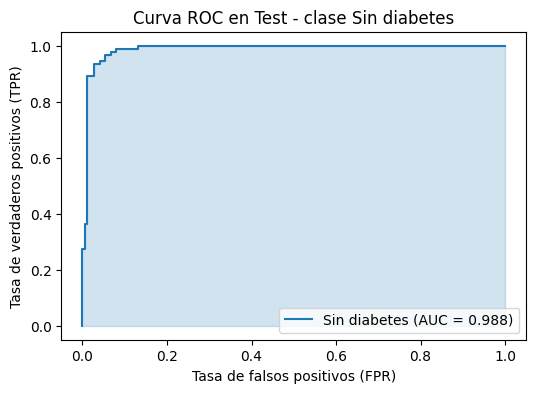

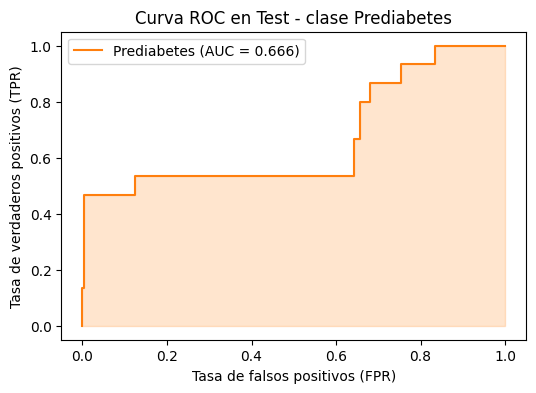

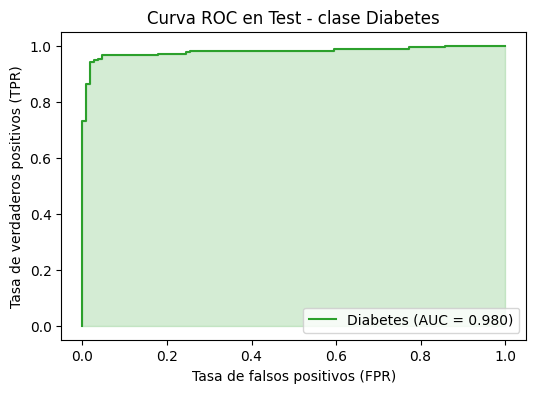

In [24]:
# Cargar las etiquetas reales y las predicciones de probabilidad
y_true_SVC = y_test
y_pred_proba_SVC = modelo_SVC.decision_function(X_test_scaled)

# Colores para las curvas, un color por curva
colores = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Nombre de las clases
class_names = ['Sin diabetes', 'Prediabetes', 'Diabetes']

# Curva ROC para cada una de las 3 clases
for i in range(3):
    # Binarizar las etiquetas y las predicciones para la clase i
    y_true_bin_SVC = (y_true_SVC == i).astype(int)
    # Extraer las probabilidades para una clase determinada
    y_pred_proba_bin_SVC = y_pred_proba_SVC[:, i]

    # Calcular FPR, TPR y AUC para poder graficar la curva
    fpr_SVC, tpr_SVC, thresholds_SVC = roc_curve(y_true_bin_SVC, y_pred_proba_bin_SVC)
    auc_score_SVC = auc(fpr_SVC, tpr_SVC)

    # Graficar la curva ROC individual
    plt.figure(figsize=(6, 4))
    plt.plot(fpr_SVC, tpr_SVC, color=colores[i], label='{} (AUC = {:.3f})'.format(class_names[i], auc_score_SVC))
    plt.fill_between(fpr_SVC, tpr_SVC, alpha=0.2, color=colores[i])
    plt.xlabel('Tasa de falsos positivos (FPR)')
    plt.ylabel('Tasa de verdaderos positivos (TPR)')
    plt.legend()
    plt.title('Curva ROC en Test - clase ' + class_names[i])

# Mostrar resumen de AUC
print("AUC por clase:")
for i in range(3):
    y_true_bin_SVC = (y_true_SVC == i).astype(int)
    y_pred_proba_bin_SVC = y_pred_proba_SVC[:, i]
    # Calculo del auc para cada clase con sus probabilidades
    auc_score_SVC = auc(roc_curve(y_true_bin_SVC, y_pred_proba_bin_SVC)[0],
                    roc_curve(y_true_bin_SVC, y_pred_proba_bin_SVC)[1])
    print(f"{class_names[i]}: {auc_score_SVC:.3f}")

plt.show()

### **2.3. Clasificador Gaussian Naive Bayes**

Realización del modelo

In [25]:
# Variables independientes
X = df_propio.drop(columns=['Class', 'ID'])

# Variable objetivo
y = df_propio['Class']

# Division del conjunto de datos en 40% test y 60% train
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# Escalado de los datos
# con el objetivo de que no predomine ninguna caracteristica y pueda haber
# resultados incorrectos
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# Creacion del modelo de clasificacion Naive Bayes
# Parametros utilizados y sus valores para realizar el modelo:
# var_smoothing=1e-03, para evitar problemas numericos, donde la varianza de
# las caracteristicas es muy baja
classifier = GaussianNB(var_smoothing=1e-03)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

**Resultados en train**

Matriz de confusión

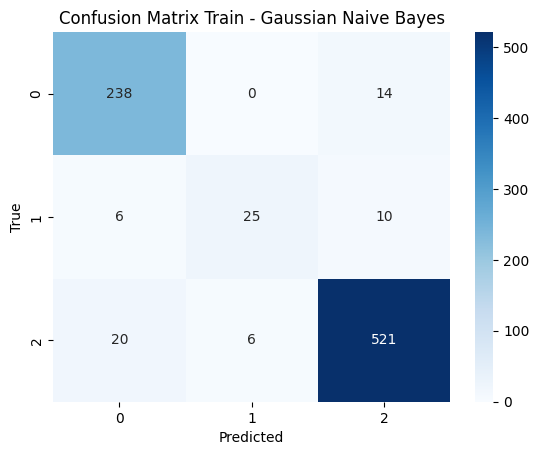

In [26]:
# Calculo y representacion grafica de la matriz de confusion para train
cm_train_GNB = confusion_matrix(y_train, classifier.predict(x_train))
sns.heatmap(cm_train_GNB, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Train - Gaussian Naive Bayes')
plt.show()

Métricas

In [27]:
# Calculo de las métricas para train
# Metricas empleadas: precision, recall, f1-score y especificidad
report_GNB_train = classification_report(y_true=y_train, y_pred=classifier.predict(x_train))
print('Métricas para train:')
print(report_GNB_train)

Métricas para train:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       252
           1       0.81      0.61      0.69        41
           2       0.96      0.95      0.95       547

    accuracy                           0.93       840
   macro avg       0.89      0.84      0.86       840
weighted avg       0.93      0.93      0.93       840



In [29]:
# Calculo de la especificidad que no esta en el report
specificity_class_0_GNB_train = calc_specificity(cm_train_GNB, 0)
specificity_class_1_GNB_train = calc_specificity(cm_train_GNB, 1)
specificity_class_2_GNB_train = calc_specificity(cm_train_GNB, 2)

# Impresion por pantalla
print('Especificidad por clase en train:')
print("Clase 0:", specificity_class_0_GNB_train)
print("Clase 1:", specificity_class_1_GNB_train)
print("Clase 2:", specificity_class_2_GNB_train)

Especificidad por clase en train:
Clase 0: 0.9444444444444444
Clase 1: 0.6097560975609756
Clase 2: 0.9524680073126143


Curva ROC

AUC por clase:
Sin diabetes: 0.984
Prediabetes: 0.988
Diabetes: 0.982


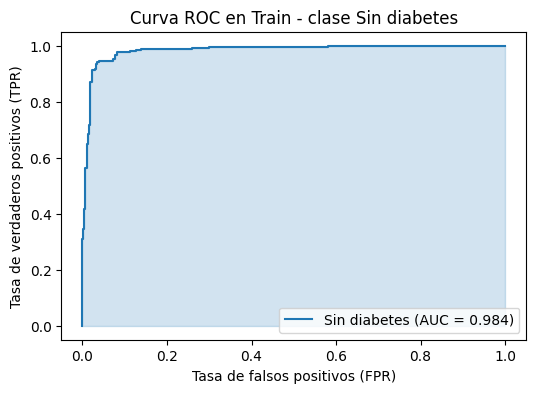

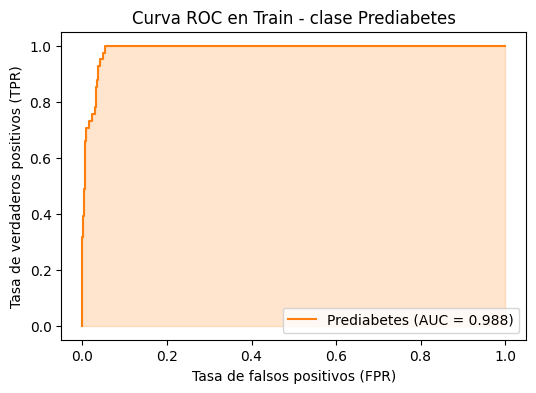

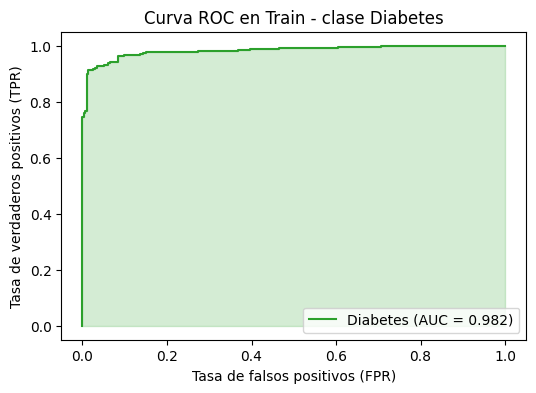

In [30]:
# Cargar las etiquetas reales y las predicciones de probabilidad
y_true = y_train
y_pred_proba = classifier.predict_proba(x_train)

# Colores para las curvas, un color para cada curva
colores = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Nombre de las clases
class_names = ['Sin diabetes', 'Prediabetes', 'Diabetes']

for i in range(3):
    # Binarizar las etiquetas y las predicciones para la clase i
    y_true_bin = (y_true == i).astype(int)
    # Extraer las probabilidades para una clase determinada
    y_pred_proba_bin = y_pred_proba[:, i]

    # Calcular FPR, TPR y AUC para poder graficar la curva
    fpr, tpr, thresholds = roc_curve(y_true_bin, y_pred_proba_bin)
    auc_score = auc(fpr, tpr)

    # Graficar la curva ROC individual
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color=colores[i], label='{} (AUC = {:.3f})'.format(class_names[i], auc_score))
    plt.fill_between(fpr, tpr, alpha=0.2, color=colores[i])
    plt.xlabel('Tasa de falsos positivos (FPR)')
    plt.ylabel('Tasa de verdaderos positivos (TPR)')
    plt.legend()
    plt.title('Curva ROC en Train - clase ' + class_names[i])

# Mostrar resumen de AUC
print("AUC por clase:")
for i in range(3):
    y_true_bin = (y_true == i).astype(int)
    y_pred_proba_bin = y_pred_proba[:, i]
    # Calculo del auc para cada clase con sus probabilidades
    auc_score = auc(roc_curve(y_true_bin, y_pred_proba_bin)[0],
                    roc_curve(y_true_bin, y_pred_proba_bin)[1])
    print(f"{class_names[i]}: {auc_score:.3f}")

plt.show()

**Resultados en test**

Matriz de confusión

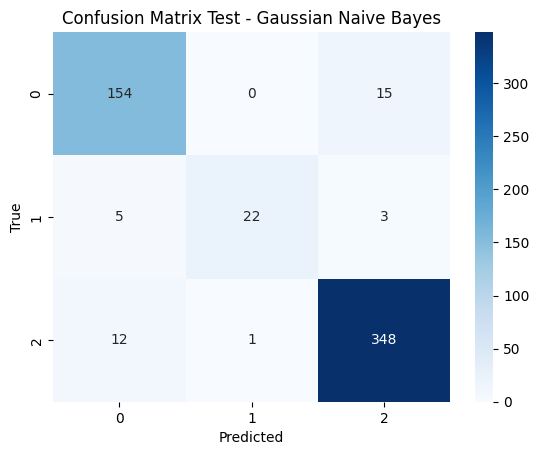

In [31]:
# Calculo y representacion grafica de la matriz de confusion para test
cm_test_GNB = confusion_matrix(y_test, classifier.predict(x_test))
sns.heatmap(cm_test_GNB, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Test - Gaussian Naive Bayes')
plt.show()

Métricas

In [32]:
# Calculo de las métricas para
# Metricas empleadas: precision, recall, f1-score y especificidad
report_GNB_test = classification_report(y_true=y_test, y_pred=y_pred)
print('Métricas para test:')
print(report_GNB_test)

Métricas para test:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       169
           1       0.96      0.73      0.83        30
           2       0.95      0.96      0.96       361

    accuracy                           0.94       560
   macro avg       0.94      0.87      0.90       560
weighted avg       0.94      0.94      0.94       560



In [33]:
# Calculo de la especificidad que no esta en el report
specificity_class_0_GNB_test = calc_specificity(cm_test_GNB, 0)
specificity_class_1_GNB_test = calc_specificity(cm_test_GNB, 1)
specificity_class_2_GNB_test = calc_specificity(cm_test_GNB, 2)

# Impresion de la especificidad
print('Especificidad por clase en test:')
print("Clase 0:", specificity_class_0_GNB_test)
print("Clase 1:", specificity_class_1_GNB_test)
print("Clase 2:", specificity_class_2_GNB_test)

Especificidad por clase en test:
Clase 0: 0.9112426035502958
Clase 1: 0.7333333333333333
Clase 2: 0.96398891966759


Curva ROC

AUC por clase:
Sin diabetes: 0.973
Prediabetes: 0.993
Diabetes: 0.978


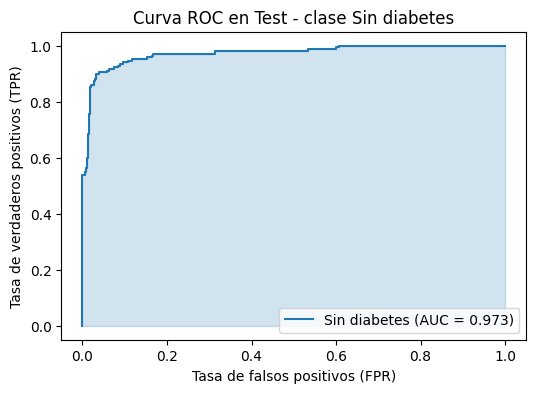

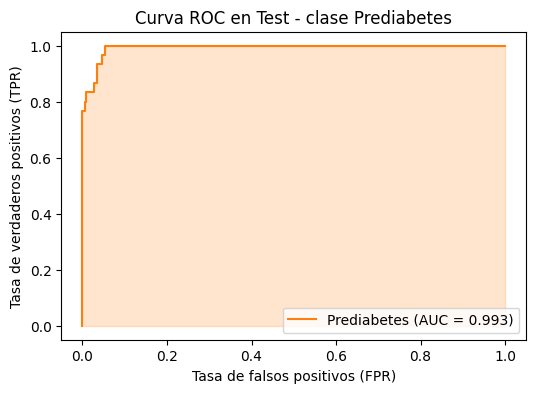

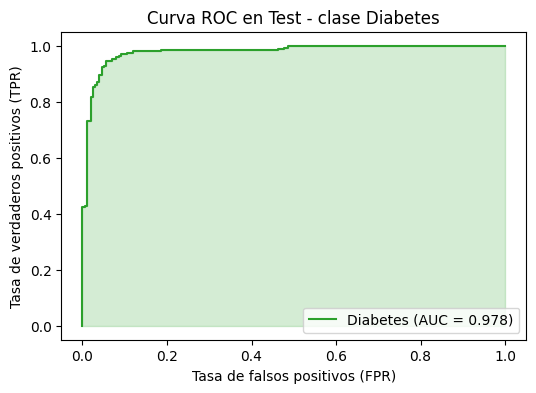

In [34]:
# Cargar las etiquetas reales y las predicciones de probabilidad
y_true = y_test
y_pred_proba = classifier.predict_proba(x_test)

# Colores para las curvas, un color para cada curva
colores = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Nombre de las clases
class_names = ['Sin diabetes', 'Prediabetes', 'Diabetes']

# Curva ROC para cada una de las 3 clases
for i in range(3):
    # Binarizar las etiquetas y las predicciones para la clase i
    y_true_bin = (y_true == i).astype(int)
    # Extraer las probabilidades para una clase determinada
    y_pred_proba_bin = y_pred_proba[:, i]

    # Calcular FPR, TPR y AUC para poder graficar la curva
    fpr, tpr, thresholds = roc_curve(y_true_bin, y_pred_proba_bin)
    auc_score = auc(fpr, tpr)

    # Graficar la curva ROC individual para cada clase
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color=colores[i], label='{} (AUC = {:.3f})'.format(class_names[i], auc_score))
    plt.fill_between(fpr, tpr, alpha=0.2, color=colores[i])
    plt.xlabel('Tasa de falsos positivos (FPR)')
    plt.ylabel('Tasa de verdaderos positivos (TPR)')
    plt.legend()
    plt.title('Curva ROC en Test - clase ' + class_names[i])

# Mostrar resumen de AUC
print("AUC por clase:")
for i in range(3):
    y_true_bin = (y_true == i).astype(int)
    y_pred_proba_bin = y_pred_proba[:, i]
    # Calculo del auc para cada clase con sus probabilidades
    auc_score = auc(roc_curve(y_true_bin, y_pred_proba_bin)[0],
                    roc_curve(y_true_bin, y_pred_proba_bin)[1])
    print(f"{class_names[i]}: {auc_score:.3f}")

plt.show()

### **2.4. Modelo Ensamblado**

**Extreme Gradient Boosting**

In [35]:
# Variables independientes
X = df_propio.drop(columns=['Class', 'ID'])

# Variable objetivo
y = df_propio['Class']

# Division en train 80% y test 20% del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state=123)
# Escalado de los datos
# para evitar resultados errones donde domina mas una caracteristica que las
# demas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenamiento del modelo XGBoost
# Parametros utilizados para crear el modelo:
# multi_class: logistic - clasifica entre multiples clases utilizado una regresion
# logistica
# n_estimators: 10 - entreno del modelo con 10 arboles de decision
clf_xgb = xgb.XGBClassifier(objective='multi_class:logistic', n_estimators=10, seed=123)
clf_xgb.fit(X_train_scaled, y_train)

# Realizacion de predicciones en el conjunto de test
preds_xgb = clf_xgb.predict(X_test_scaled)

**Resultados en test**

Matriz de confusión


XGBoost Confusion Matrix:
[[ 76   0   0]
 [  0   7   0]
 [  1   0 196]]


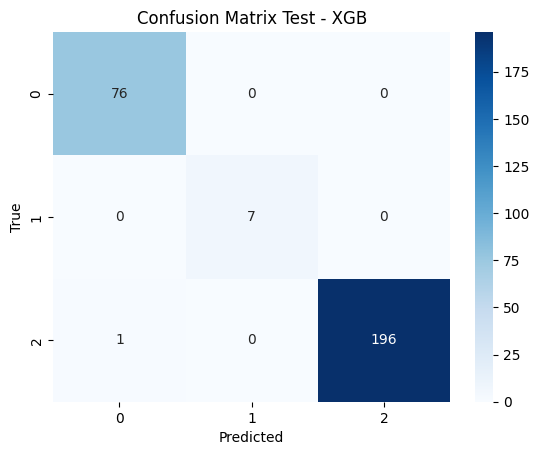

In [36]:
# Creacion de las matriz de confusion para test  y visualizacion
print("\nXGBoost Confusion Matrix:")
cm_xgb = confusion_matrix(y_test, preds_xgb)
print(cm_xgb)

cm_test_XGB= confusion_matrix(y_test, preds_xgb)
sns.heatmap(cm_test_XGB, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Test - XGB')
plt.show()

Métricas

In [37]:
# Calculo de las métricas para test
# Metricas usadas: precision, recall, f1-score y especificidad
report_xgb_test = classification_report(y_true=y_test, y_pred=preds_xgb)
print('Métricas para test:')
print(report_xgb_test)

Métricas para test:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        76
           1       1.00      1.00      1.00         7
           2       1.00      0.99      1.00       197

    accuracy                           1.00       280
   macro avg       1.00      1.00      1.00       280
weighted avg       1.00      1.00      1.00       280



In [38]:
# Calculo de la especificidad, ya que no aparece en el report
specificity_class_0_xgb = calc_specificity(cm_test_XGB, 0)
specificity_class_1_xgb = calc_specificity(cm_test_XGB, 1)
specificity_class_2_xgb = calc_specificity(cm_test_XGB, 2)

# Impresion por pantalla
print('Especificidad por clase en test:')
print("Especificidad clase 0:", specificity_class_0_xgb)
print("Especificidad clase 1:", specificity_class_1_xgb)
print("Especificidad clase 2:", specificity_class_2_xgb)

Especificidad por clase en test:
Especificidad clase 0: 1.0
Especificidad clase 1: 1.0
Especificidad clase 2: 0.9949238578680203


Curva ROC

AUC por clase:
Sin diabetes: 1.000
Prediabetes: 1.000
Diabetes: 1.000


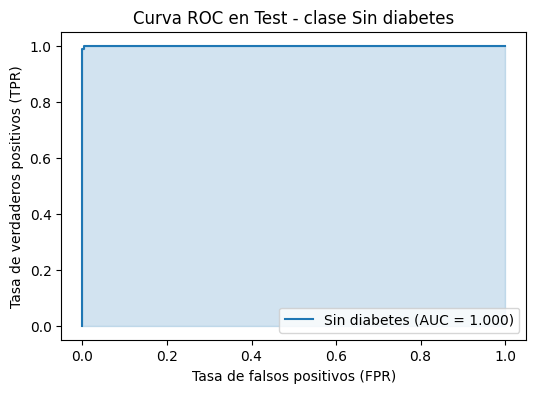

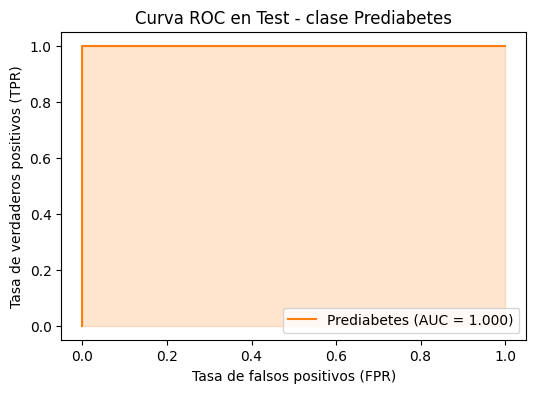

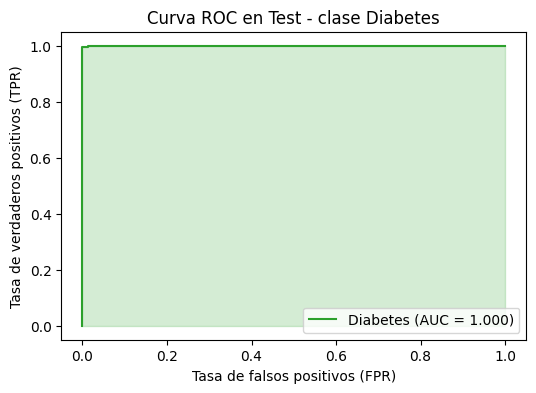

In [39]:
# Cargar las etiquetas reales y las predicciones de probabilidad
y_true = y_test
y_pred_proba = clf_xgb.predict_proba(X_test_scaled)

# Colores para las curvas, un color para cada curva
colores = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Nombre para cada clase
class_names = ['Sin diabetes', 'Prediabetes', 'Diabetes']

# Calculo de la curva ROC para cada una de las 3 clases
for i in range(3):
    # Binarizar las etiquetas y las predicciones para la clase i
    y_true_bin = (y_true == i).astype(int)
    # Extraer las probabilidades para una clase determinada
    y_pred_proba_bin = y_pred_proba[:, i]

    # Calcular FPR, TPR y AUC para poder graficar la curva
    fpr, tpr, thresholds = roc_curve(y_true_bin, y_pred_proba_bin)
    auc_score = auc(fpr, tpr)

    # Graficar la curva ROC individual
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color=colores[i], label='{} (AUC = {:.3f})'.format(class_names[i], auc_score))
    plt.fill_between(fpr, tpr, alpha=0.2, color=colores[i])
    plt.xlabel('Tasa de falsos positivos (FPR)')
    plt.ylabel('Tasa de verdaderos positivos (TPR)')
    plt.legend()
    plt.title('Curva ROC en Test - clase ' + class_names[i])

# Mostrar resumen de AUC
print("AUC por clase:")
for i in range(3):
    y_true_bin = (y_true == i).astype(int)
    y_pred_proba_bin = y_pred_proba[:, i]
    # Calculo del auc para cada clase con sus probabilidades
    auc_score = auc(roc_curve(y_true_bin, y_pred_proba_bin)[0],
                    roc_curve(y_true_bin, y_pred_proba_bin)[1])
    print(f"{class_names[i]}: {auc_score:.3f}")

plt.show()

**Resultados obtenidos en train**

Matriz de confusión

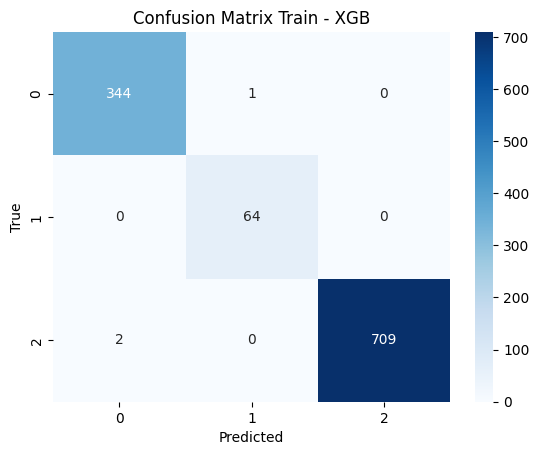

In [40]:
# Creacion y visualizacion de la matriz de confusion en train
cm_train_XGB = confusion_matrix(y_train, clf_xgb.predict(X_train_scaled))
sns.heatmap(cm_train_XGB, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Train - XGB')
plt.show()

Métricas

In [41]:
# Calculo de las métricas para train
# Uso de las metricas: precision, recall, f1-score y especificidad
report_xgb_train = classification_report(y_true=y_train, y_pred=clf_xgb.predict(X_train_scaled))
print('Métricas para train:')
print(report_xgb_train)

Métricas para train:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       345
           1       0.98      1.00      0.99        64
           2       1.00      1.00      1.00       711

    accuracy                           1.00      1120
   macro avg       0.99      1.00      1.00      1120
weighted avg       1.00      1.00      1.00      1120



In [42]:
# Calculo de la especifcidad, que no viene en el report
specificity_class_0_xgb_train = calc_specificity(cm_train_XGB, 0)
specificity_class_1_xgb_train = calc_specificity(cm_train_XGB, 1)
specificity_class_2_xgb_train = calc_specificity(cm_train_XGB, 2)

# Impresion de los resultados
print('Especificidad por clase en train:')
print("Especificidad clase 0:", specificity_class_0_xgb_train)
print("Especificidad clase 1:", specificity_class_1_xgb_train)
print("Especificidad clase 2:", specificity_class_2_xgb_train)

Especificidad por clase en train:
Especificidad clase 0: 0.9971014492753624
Especificidad clase 1: 1.0
Especificidad clase 2: 0.9971870604781997


Curva ROC

AUC por clase:
Sin diabetes: 1.000
Prediabetes: 1.000
Diabetes: 1.000


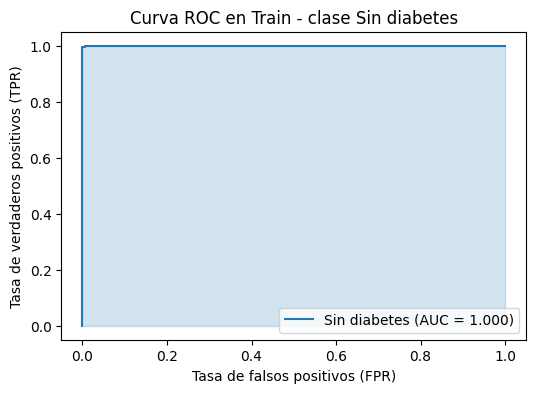

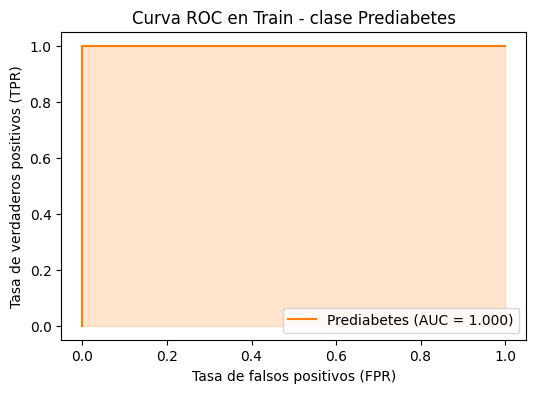

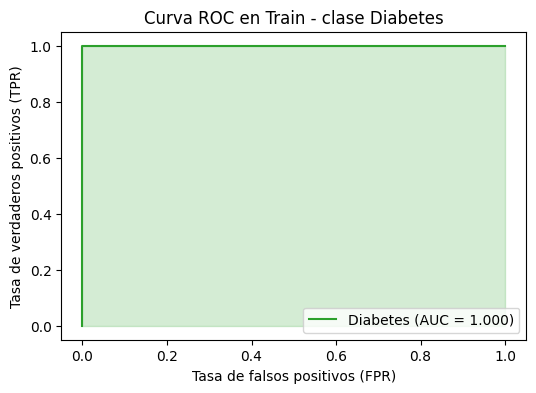

In [43]:
# Cargar las etiquetas reales y las predicciones de probabilidad
y_true = y_train
y_pred_proba = clf_xgb.predict_proba(X_train_scaled)

# Colores para las curvas, un color por cada curva
colores = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Nombre para cada clase
class_names = ['Sin diabetes', 'Prediabetes', 'Diabetes']

# Calculo de la curva ROC para cada clase
for i in range(3):
    # Binarizar las etiquetas y las predicciones para la clase i
    y_true_bin = (y_true == i).astype(int)
    # Extraer las probabilidades para una clase determinada
    y_pred_proba_bin = y_pred_proba[:, i]

    # Calcular FPR, TPR y AUC para poder graficar la curva
    fpr, tpr, thresholds = roc_curve(y_true_bin, y_pred_proba_bin)
    auc_score = auc(fpr, tpr)

    # Graficar la curva ROC individual
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color=colores[i], label='{} (AUC = {:.3f})'.format(class_names[i], auc_score))
    plt.fill_between(fpr, tpr, alpha=0.2, color=colores[i])
    plt.xlabel('Tasa de falsos positivos (FPR)')
    plt.ylabel('Tasa de verdaderos positivos (TPR)')
    plt.legend()
    plt.title('Curva ROC en Train - clase ' + class_names[i])

# Mostrar resumen de AUC
print("AUC por clase:")
for i in range(3):
    y_true_bin = (y_true == i).astype(int)
    y_pred_proba_bin = y_pred_proba[:, i]
    # Calculo del auc para cada clase con sus probabilidades
    auc_score = auc(roc_curve(y_true_bin, y_pred_proba_bin)[0],
    roc_curve(y_true_bin, y_pred_proba_bin)[1])
    print(f"{class_names[i]}: {auc_score:.3f}")

plt.show()